In [15]:
from __future__ import annotations

import os
import pathlib
import random
import subprocess
import tempfile
import timeit

import matplotlib.pyplot as plt
import numpy as np

TARGET_COMMAND = "sha256sum"

# note: input data given as string so that encoding approaches can be taken into account
INPUT_SIZE = 300  # 16 * 2 ** 10
INPUT_DATA = random.randbytes(INPUT_SIZE).hex()

In [16]:
def py6s_native():
    """
    Mimics Py6S's multiprocessing approach.
    """
    tmp_file = tempfile.NamedTemporaryFile(
        prefix="tmp_Py6S_input_benchmark", delete=False
    )

    tmp_file.file.write(bytes(INPUT_DATA, "utf-8"))
    tmp_file.close()

    process = subprocess.Popen(
        "%s < %s" % (TARGET_COMMAND, tmp_file.name),
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    outputs = process.communicate()
    outputs[0].decode("utf-8")
    outputs[1].decode("utf-8")
    os.remove(tmp_file.name)


def py6s_no_shell():
    """
    Mimics Py6S's multiprocessing approach.
    """
    tmp_file = tempfile.NamedTemporaryFile(
        prefix="tmp_Py6S_input_benchmark", delete=False
    )

    tmp_file.file.write(bytes(INPUT_DATA, "utf-8"))
    tmp_file.close()

    process = subprocess.Popen(
        "%s" % (TARGET_COMMAND),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    outputs = process.communicate(pathlib.Path(tmp_file.name).read_text())
    outputs[0].decode("utf-8")
    outputs[1].decode("utf-8")
    os.remove(tmp_file.name)


def candidate_1():
    subprocess.run(
        [TARGET_COMMAND],
        input=INPUT_DATA,
        text=True,
        check=True,
        capture_output=True,
    )


def candidate_2():
    subprocess.run(
        [TARGET_COMMAND],
        input=INPUT_DATA,
        text=True,
        check=True,
        capture_output=True,
        encoding="ascii",
    )


def candidate_3():
    s = subprocess
    process = s.Popen(
        [TARGET_COMMAND],
        stdout=s.PIPE,
        stderr=s.PIPE,
    )
    stdout, stderr = process.communicate(INPUT_DATA.encode("ascii"))
    stdout.decode("ascii")
    stderr.decode("ascii")


def candidate_4():
    s = subprocess
    process = s.Popen(
        [TARGET_COMMAND],
        stdout=s.PIPE,
        stderr=s.PIPE,
    )
    stdout, stderr = process.communicate(INPUT_DATA.encode("ascii"))
    stdout.decode("utf-8")
    stderr.decode("utf-8")


def candidate_5():
    s = subprocess
    process = s.Popen(
        TARGET_COMMAND,
        stdout=s.PIPE,
        stderr=s.PIPE,
    )
    stdout, stderr = process.communicate(INPUT_DATA.encode("ascii"))
    stdout.decode("utf-8")
    stderr.decode("utf-8")


approach_funcs = [
    py6s_native,
    py6s_no_shell,
    candidate_1,
    candidate_2,
    candidate_3,
    candidate_4,
    candidate_5,
]

In [17]:
# Number of trials to average over.
num_trials = 3

# Simulation sizes to test (=number of processes spawned).
simulation_sizes = [1, 3, 10, 30, 100, 300, 1_000, 10_000, 30_000]

results = np.empty((len(approach_funcs), len(simulation_sizes)))

for approach_idx, func in enumerate(approach_funcs):
    for size_idx, sim_size in enumerate(simulation_sizes):
        print(f"Benchmarking {func.__name__} with size={sim_size:4d}... ", end="")
        runtimes = timeit.repeat(func, repeat=num_trials, number=sim_size)
        avg = np.mean(runtimes)
        results[approach_idx, size_idx] = avg
        print(f"{avg:7.3f}s ({avg/sim_size:7f} s/it, {sim_size/avg:7f} it/s)")

print("done")

Benchmarking py6s_native with size=   1...   0.002s (0.001544 s/it, 647.727406 it/s)
Benchmarking py6s_native with size=   3...   0.004s (0.001187 s/it, 842.312857 it/s)
Benchmarking py6s_native with size=  10...   0.013s (0.001258 s/it, 794.644330 it/s)
Benchmarking py6s_native with size=  30...   0.027s (0.000914 s/it, 1094.161722 it/s)
Benchmarking py6s_native with size= 100...   0.104s (0.001039 s/it, 962.298252 it/s)
Benchmarking py6s_native with size= 300...   0.444s (0.001481 s/it, 675.298346 it/s)
Benchmarking py6s_native with size=1000...   1.340s (0.001340 s/it, 746.305046 it/s)
Benchmarking py6s_native with size=10000...  13.578s (0.001358 s/it, 736.489886 it/s)
Benchmarking py6s_native with size=30000...  36.106s (0.001204 s/it, 830.885371 it/s)
Benchmarking py6s_no_shell with size=   1...   0.001s (0.000644 s/it, 1552.719469 it/s)
Benchmarking py6s_no_shell with size=   3...   0.002s (0.000660 s/it, 1516.186549 it/s)
Benchmarking py6s_no_shell with size=  10...   0.006s (0

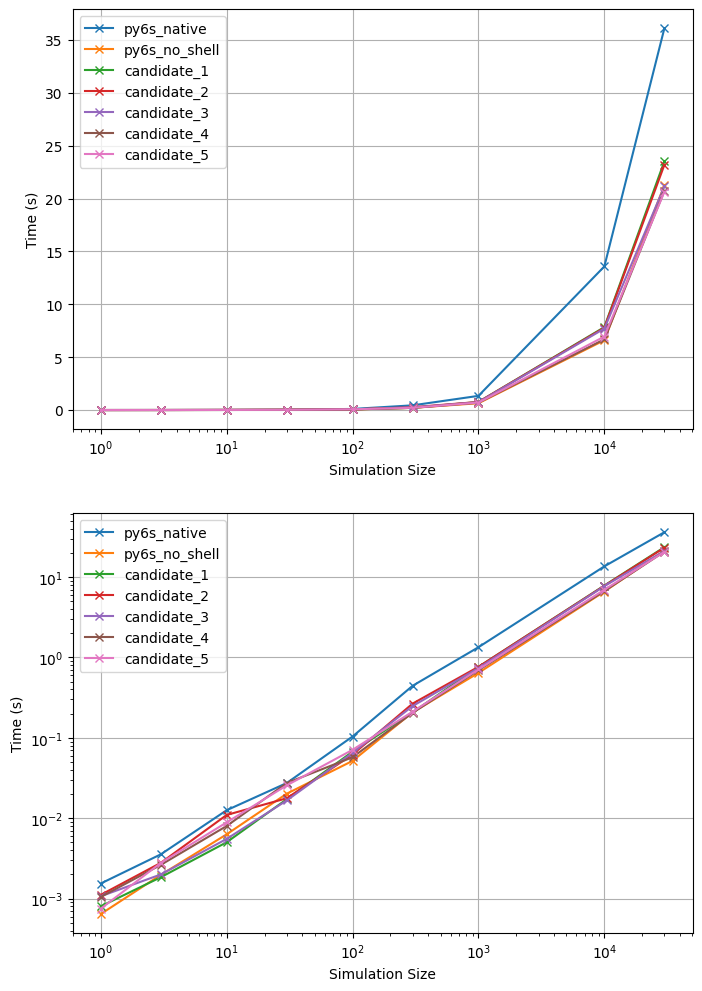

In [18]:
from matplotlib.axes import Axes

fig, axs = plt.subplots(nrows=2, figsize=(8, 12))

for approach_idx, func in enumerate(approach_funcs):
    ax = axs[0]
    ax.semilogx(simulation_sizes, results[approach_idx, :], "x-", label=func.__name__)
    ax.legend()
    ax.set_ylabel("Time (s)")
    ax.set_xlabel("Simulation Size")
    ax.grid(True)

    ax = axs[1]
    ax.loglog(simulation_sizes, results[approach_idx, :], "x-", label=func.__name__)
    ax.legend()
    ax.set_ylabel("Time (s)")
    ax.set_xlabel("Simulation Size")
    ax.grid(True)